In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle

from util import *
import scanpy.api as sc
import data_loader as dl
import scdd as sd
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Simulation

In [28]:
data = dl.load_10x_4k()
sc.pp.filter_genes(data,min_counts=0.2*data.shape[0])
mean_ = data.X.mean(axis=0)
var_ = data.X.todense().var(axis=0)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


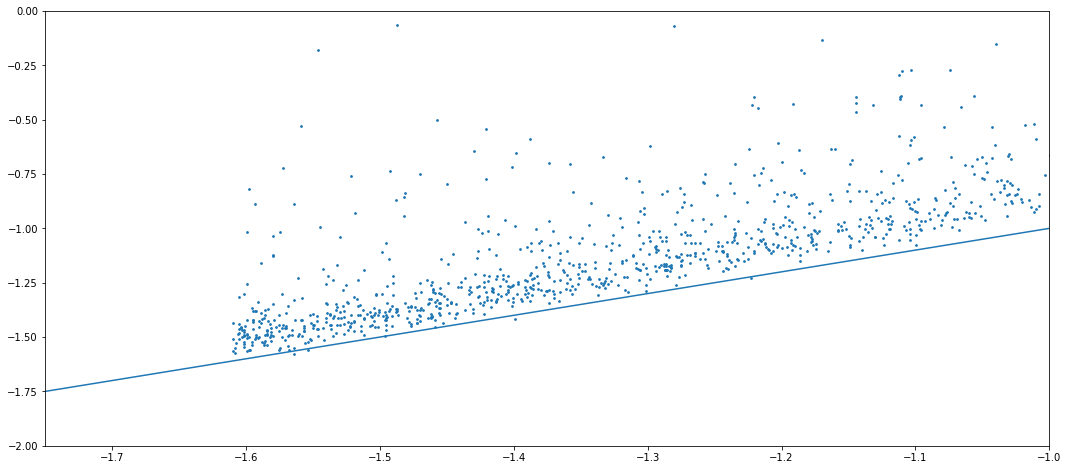

In [43]:
plt.figure(figsize=[18,8])
plt.scatter(np.log(np.array(mean_)).reshape(-1),np.log(np.array(var_)).reshape(-1),alpha=1,s=3)
plt.plot([-2,5],[-2,5])
plt.xlim([-1.75,-1])
plt.ylim([-2,0])
plt.show()

the toy true distribution


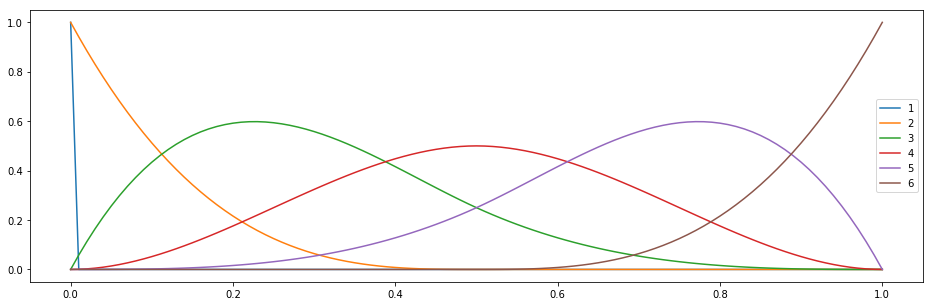

[ 3  2 -4  5 -2 -2]
--- ccdf ---
>0.05: 37.84%
>0.1: 36.09%
>0.15: 35.22%
>0.2: 34.57%
>0.25: 33.88%
>0.3: 32.97%
>0.35: 31.92%
>0.4: 29.37%


<Figure size 432x288 with 0 Axes>

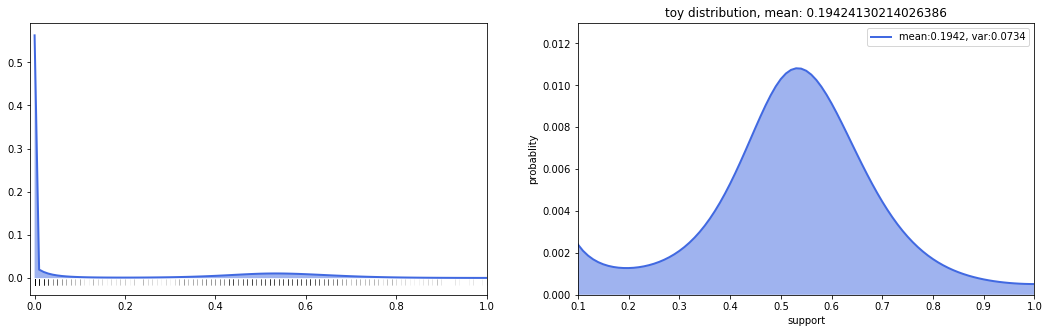

In [2]:
## creating a toy 1d distribution instance
print('the toy true distribution')
p,x_grid=dl.load_1d_toy_spline(verbose=True)
Y,x_samp = sd.Y_gen(p,x_grid,Nc=10000,Nr=10)

n_degree: 5, c_reg: 0.0001, gamma: 10

alpha [ 5.19394139  1.03504617 -2.99861822  5.28424246  0.03793718 -2.86784248]
--- ccdf ---
>0.05: 37.49%
>0.1: 35.90%
>0.15: 35.11%
>0.2: 34.48%
>0.25: 33.77%
>0.3: 32.92%
>0.35: 31.55%
>0.4: 29.51%


<Figure size 432x288 with 0 Axes>

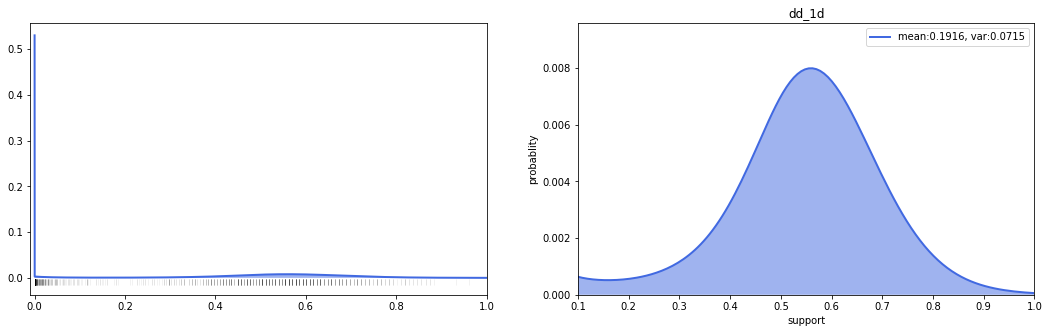

error 0.021609653397451807


In [3]:
p_dd,x_dd = sd.dd_distribution(Y,gamma=10,verbose=True)
print('error',dist_W1(p,p_dd,x_grid,x_dd))

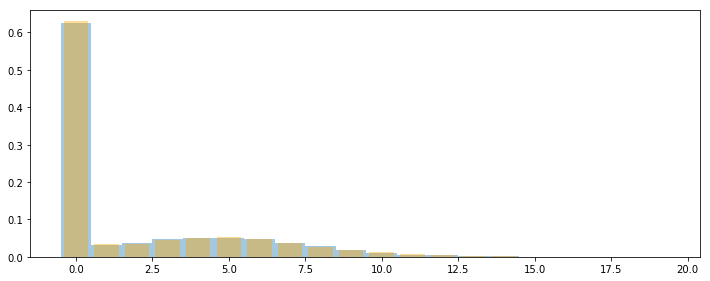

In [4]:
## Map the distrbution back 
Y_dd = np.arange(20)
P_model = sd.Pmodel_cal(x_dd,Y_dd,10)
pY_dd = P_model.dot(p_dd)
bins_ = np.linspace(-0.5,Y.max()+0.5,Y.max()+2)
plt.figure(figsize=[12,10])
plt.subplot(211)
plt.hist(Y,weights=np.ones([Y.shape[0]])/Y.shape[0],bins=bins_,alpha=0.4)
plt.bar(Y_dd,pY_dd,color='orange',alpha=0.4)
plt.show()

# Some real data

In [5]:
def quantization(x_dd,p_dd):
    x_dd_new = np.arange(np.ceil(x_dd.max())+1)
    p_dd_new = np.zeros([x_dd_new.shape[0]])
    for i in range(p_dd.shape[0]):
        lb = np.floor(x_dd[i]).astype(int)
        ub = np.ceil(x_dd[i]).astype(int)
        if lb==ub:
            p_dd_new[lb] += p_dd[i]
        else:
#             p_dd_new[lb] += p_dd[i] * (x_dd[i]-lb<0.5) 
#             p_dd_new[ub] += p_dd[i] * (x_dd[i]-lb>=0.5) 
              p_dd_new[lb] += p_dd[i] * (ub - x_dd[i]) 
              p_dd_new[ub] += p_dd[i] * (x_dd[i]-lb) 
    return x_dd_new,p_dd_new

In [9]:
data = dl.load_10x_4k()
data = dl.load_10x_68k()
sc.pp.filter_genes(data,min_counts=0.5*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)
data_subsample = sd.subsample_anndata(data,Nr/5,Nc)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=68579, G=283, Nr=947.2, Nr_bar=3.3
#time start: 0.0s
before cell subsamp (68579, 283)
after cell subsamp (68579, 283)
#time sub-sample cells: 0.1475s
## 5000 cells processed
## 10000 cells processed
## 15000 cells processed
## 20000 cells processed
## 25000 cells processed
## 30000 cells processed
## 35000 cells processed
## 40000 cells processed
## 45000 cells processed
## 50000 cells processed
## 55000 cells processed
## 60000 cells processed
## 65000 cells processed
#time sub-sample counts: 44.8291s



n_degree: 5, c_reg: 0.001, gamma: 8

alpha [ -4.20046831  23.87456738  29.93772106 -44.75997214  -6.80649817
  -1.89315028]
--- ccdf ---
>0.05: 25.88%
>0.1: 1.963%
>0.15: 0.042%
>0.2: 0.000%
>0.25: 6.887%
>0.3: 2.144%
>0.35: 2.854%
>0.4: 2.430%


<Figure size 432x288 with 0 Axes>

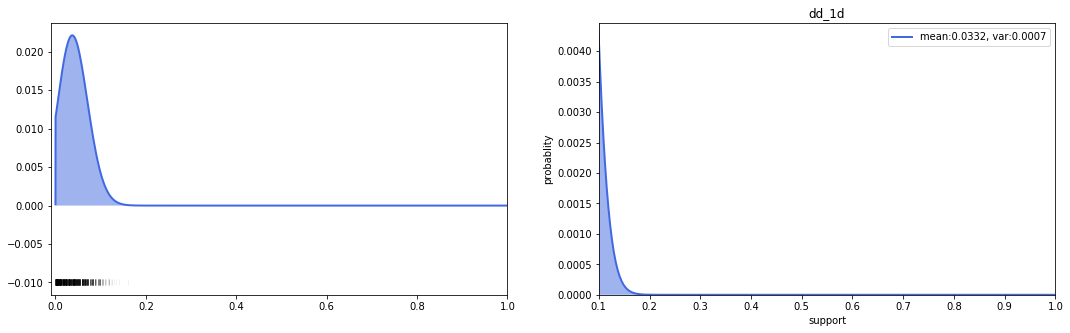

error ml 0.8144048521607288
error dd 0.25686047275633883


In [10]:
gene = 'CD3D'

Y = np.array(data[:,gene].X).reshape(-1).astype(int)
Y_sub = np.array(data_subsample[:,gene].X).reshape(-1).astype(int)

p_full = np.bincount(Y)
p_full = p_full / p_full.sum()
x_full = np.arange(p_full.shape[0])  
p_ml = np.bincount(Y_sub)
p_ml = p_ml / p_ml.sum()
x_ml = np.arange(p_ml.shape[0])            
p_dd,x_dd = sd.dd_distribution(Y_sub,gamma=None,verbose=True,c_reg=1e-3)#,zero_esti=False)

print('error ml',dist_W1(p_full,p_ml,x_full,x_ml))
print('error dd',dist_W1(p_full,p_dd,x_full,x_dd))

0.730292558670044
0.7899234294891357
0.824152946472168


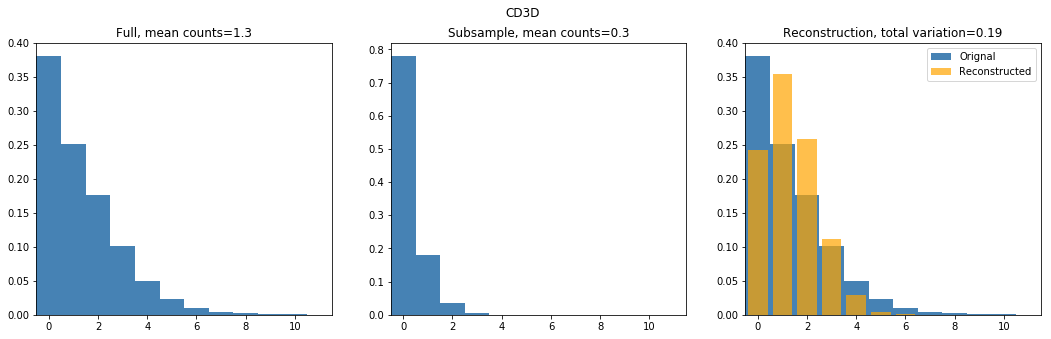

In [13]:
gene = 'S100A8'
gene = 'CD3D'
start_time = time.time()

Y = np.array(data[:,gene].X).reshape(-1).astype(int)
Y_sub = np.array(data_subsample[:,gene].X).reshape(-1).astype(int)
y_max = (np.percentile(Y,99)+5).astype(int)
bins_ = np.linspace(-0.5,y_max+0.5,y_max+2)

# p_dd,x_dd = sd.dd_distribution(Y_sub,gamma=None,verbose=False)
p_dd,x_dd = sd.dd_distribution(Y,gamma=None,verbose=False)
print(time.time()-start_time)


plt.figure(figsize=[18,5])
plt.subplot(131)
plt.hist(Y,bins=bins_,color='steelblue',weights = np.ones(Y.shape[0])/Y.shape[0])
plt.title('Full, mean counts=%0.1f'%Y.mean())
plt.xlim([bins_.min(),bins_.max()])

plt.subplot(132)
plt.hist(Y_sub,bins=bins_,color='steelblue',weights = np.ones(Y_sub.shape[0])/Y_sub.shape[0])
plt.title('Subsample, mean counts=%0.1f'%Y_sub.mean())
plt.xlim([bins_.min(),bins_.max()])
print(time.time()-start_time)

p_full = np.bincount(Y)
p_full = p_full/np.sum(p_full)    
m_full = Y.mean()
m_dd = p_dd.dot(x_dd)
x_dd_ = x_dd * m_full / m_dd
x_dd_new,p_dd_new = quantization(x_dd_,p_dd)
if p_full.shape[0]<p_dd_new.shape[0]:
    tv_dist = 0.5*np.sum(np.absolute(p_full - p_dd_new[0:p_full.shape[0]]))
else:
    tv_dist = 0.5*np.sum(np.absolute(p_full[0:p_dd_new.shape[0]] - p_dd_new))

plt.subplot(133)
plt.hist(Y,bins=bins_,weights = np.ones(Y.shape[0])/Y.shape[0],color='steelblue',alpha=1,label='Orignal')
print(time.time()-start_time)
plt.bar(x_dd_new,p_dd_new,color='orange',width=0.8, alpha=0.7,label='Reconstructed')
plt.title('Reconstruction, total variation=%0.2f'%(tv_dist))
plt.xlim([bins_.min(),bins_.max()])
plt.legend()
plt.suptitle(gene)
plt.show()



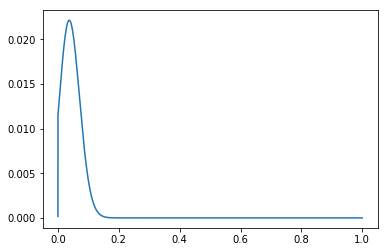

In [15]:
plt.figure()
plt.plot(x_dd,p_dd)
plt.show()

0.6328125
0.6912627220153809
0.7242231369018555


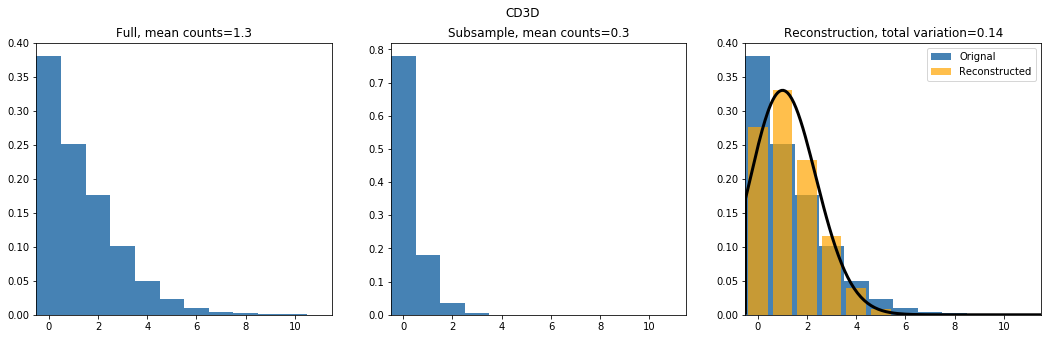

In [23]:
gene = 'S100A8'
gene = 'CD3D'
start_time = time.time()

Y = np.array(data[:,gene].X).reshape(-1).astype(int)
Y_sub = np.array(data_subsample[:,gene].X).reshape(-1).astype(int)
y_max = (np.percentile(Y,99)+5).astype(int)
bins_ = np.linspace(-0.5,y_max+0.5,y_max+2)

p_dd,x_dd = sd.dd_distribution(Y_sub,gamma=None,verbose=False)
# p_dd,x_dd = sd.dd_distribution(Y,gamma=None,verbose=False)
print(time.time()-start_time)


plt.figure(figsize=[18,5])
plt.subplot(131)
plt.hist(Y,bins=bins_,color='steelblue',weights = np.ones(Y.shape[0])/Y.shape[0])
plt.title('Full, mean counts=%0.1f'%Y.mean())
plt.xlim([bins_.min(),bins_.max()])

plt.subplot(132)
plt.hist(Y_sub,bins=bins_,color='steelblue',weights = np.ones(Y_sub.shape[0])/Y_sub.shape[0])
plt.title('Subsample, mean counts=%0.1f'%Y_sub.mean())
plt.xlim([bins_.min(),bins_.max()])
print(time.time()-start_time)

p_full = np.bincount(Y)
p_full = p_full/np.sum(p_full)    
m_full = Y.mean()
m_dd = p_dd.dot(x_dd)
x_dd_ = x_dd * m_full / m_dd
x_dd_new,p_dd_new = quantization(x_dd_,p_dd)
if p_full.shape[0]<p_dd_new.shape[0]:
    tv_dist = 0.5*np.sum(np.absolute(p_full - p_dd_new[0:p_full.shape[0]]))
else:
    tv_dist = 0.5*np.sum(np.absolute(p_full[0:p_dd_new.shape[0]] - p_dd_new))

plt.subplot(133)
plt.hist(Y,bins=bins_,weights = np.ones(Y.shape[0])/Y.shape[0],color='steelblue',alpha=1,label='Orignal')
print(time.time()-start_time)
plt.plot(x_dd_-0.5,p_dd/p_dd.max()*0.33,'k',lw=3)
plt.bar(x_dd_new,p_dd_new,color='orange',width=0.8, alpha=0.7,label='Reconstructed')
plt.title('Reconstruction, total variation=%0.2f'%(tv_dist))
plt.xlim([bins_.min(),bins_.max()])
plt.legend()
plt.suptitle(gene)
plt.show()



In [24]:
p_dd[0:5]

array([0.00017135, 0.01144044, 0.01147164, 0.01152367, 0.0115966 ])

In [25]:
x_dd_[0:5]

array([0.        , 0.00101358, 0.00405432, 0.00912222, 0.01621728])

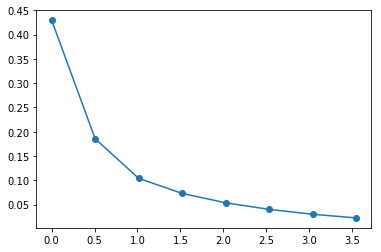

In [275]:
plt.figure()
plt.plot(x_dd_[x_dd_<4],p_dd[x_dd_<4],marker='o')
plt.show()

In [216]:
np.sum(x_dd_<1)

1000

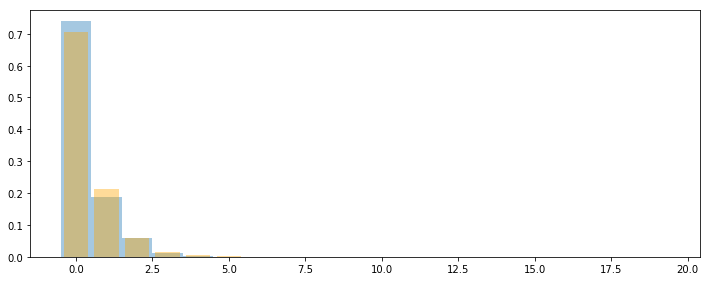

In [150]:
Y_dd = np.arange(20)
P_model = sd.Pmodel_cal(x_dd,Y_dd,10)
pY_dd = P_model.dot(p_dd)
bins_ = np.linspace(-0.5,Y.max()+0.5,Y.max()+2)
plt.figure(figsize=[12,10])
plt.subplot(211)
plt.hist(Y_sub,weights=np.ones([Y_sub.shape[0]])/Y_sub.shape[0],bins=bins_,alpha=0.4)
plt.bar(Y_dd,pY_dd,color='orange',alpha=0.4)
plt.show()

In [64]:
test1 = np.arange(5)
test2 = np.arange(3)
np.concatenate([test1,test2])

array([0, 1, 2, 3, 4, 0, 1, 2])

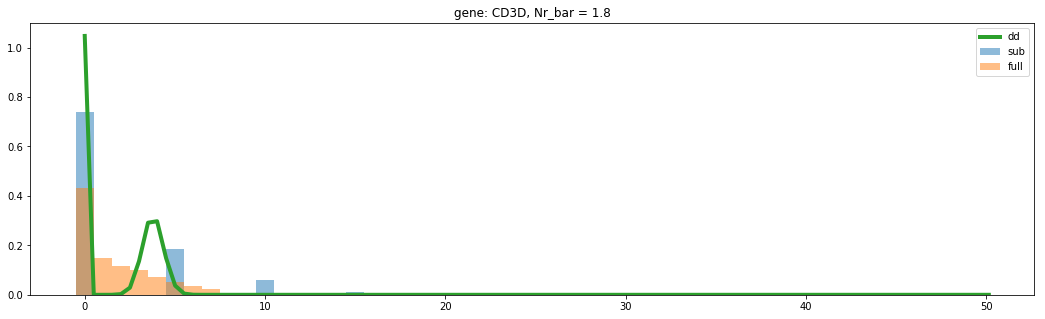

In [53]:
m_full = p_full.dot(x_full)
m_ml = p_ml.dot(x_ml)
m_dd = p_dd.dot(x_dd)
x_rec = x_dd/m_dd*m_full
x_step = x_rec[1]-x_rec[0]
plt.figure(figsize=[18,5])
plt.hist(Y_sub*m_full/m_ml,bins=bins_,weights = np.ones(Y_sub.shape[0])/Y_sub.shape[0],alpha=0.5,label='sub')
plt.hist(Y,bins=bins_,weights = np.ones(Y.shape[0])/Y.shape[0],alpha=0.5,label='full')
plt.plot(x_rec,p_dd/x_step,linewidth=4,label='dd')
plt.title('gene: %s, Nr_bar = %0.1f'%(gene,Y.mean()))
# plt.xlim([0,80])
plt.legend()
plt.show()

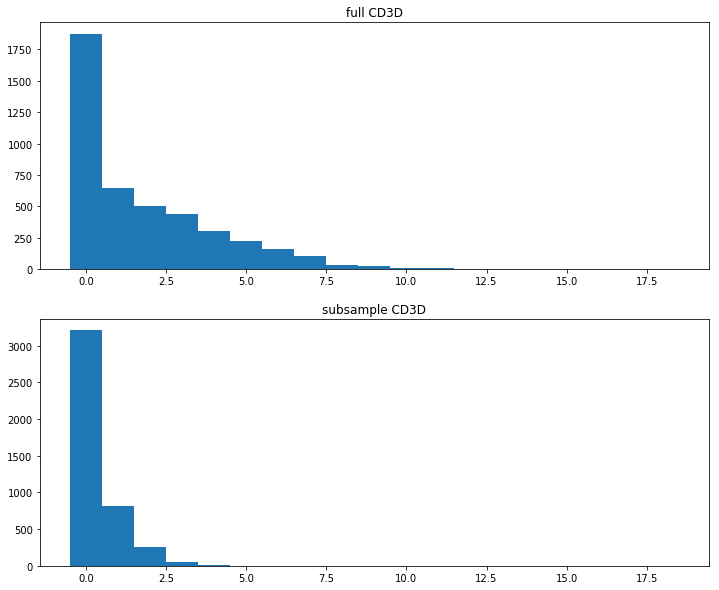

In [96]:
bins_ = np.linspace(-0.5,Y.max()+0.5,Y.max()+2)
plt.figure(figsize=[12,10])
plt.subplot(211)
plt.hist(Y,bins=bins_)
plt.title('full %s'%gene)
plt.subplot(212)
plt.hist(Y_sub,bins=bins_)
plt.title('subsample %s'%gene)
plt.show()